In [1]:
import os, json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model 


Using TensorFlow backend.


In [2]:
# this finds our json files
path_to_json = 'CORD/train/json/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data = pd.DataFrame(columns=['validline'])

f = open("receipt_words.csv", "w")
print("filename",",","index",",","x1",",",'x2',",",'x3',",",'x4',",",'y1',",",'y2',",",'y3',",",'y4',",",'is_key',",",'row_id',",",'text',",",'category',",","group_id",file=f)


# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
        
       # print(json_text)

        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        lines = json_text['valid_line']
        
        for x in lines:
            words = x['words']
            category = x['category']
            group_id = x['group_id']
            for y in words:
                print(js,index,y['quad']['x1'],y['quad']['x2'],y['quad']['x3'],y['quad']['x4'],y['quad']['y1'],y['quad']['y2'],y['quad']['y3'],y['quad']['y4'],y['is_key'],y['row_id'],"\""+y['text']+"\"",category,group_id,file=f,sep=",")

       # city = json_text['features'][0]['properties']['name']
        #lonlat = json_text['features'][0]['geometry']['coordinates']
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        #f.close()
        #jsons_data.loc[index] = [words, city, lonlat]

# now that we have the pertinent json data in our DataFrame let's look at it
f.close()

In [3]:
import pandas as pd
receipts_df = pd.read_csv("receipt_words.csv")
receipts_df.columns = receipts_df.columns.str.strip()
receipts_df['text'] = receipts_df['text'].str.strip()


In [4]:
char2idx = {"START":0,"END":1,"a":2,"b":3,"c":4,"d":5,"e":6,"f":7,"g":8,"h":9,"i":10,"j":11,"k":12,"l":13,"m":14,"n":15,"o":16,"p":17,"q":18,"r":19,"s":20,"t":21,"u":22,"v":23,"w":24,"x":25,"y":26,"z":27,"0":28,"1":29,"2":30,"3":31,"4":32,"5":33,"6":34,"7":35,"8":36,"9":37,".":38,"-":39,",":40,":":41," ":42}

In [5]:
#p_test.SentimentText=p_test.SentimentText.astype(str)
receipts_df.text = receipts_df.text.astype(str)


In [6]:
words = receipts_df['text']

In [7]:
indexed_words = []
j=43
for word in words:
    indexed_word = []
    #print(word)
    word = word.lower();
    for i in range(len(word)):
        token = word[i]
        if token not in char2idx:
            char2idx[token] = j
            j += 1
        indexed_word.append(char2idx[token])
    indexed_words.append(indexed_word)

receipts_df["indexed_words"] = indexed_words;

In [8]:
import numpy as np
def get_bigram_probs(words, V, start_idx, end_idx, smoothing=1):
  # structure of bigram probability matrix will be:
  # (last word, current word) --> probability
  # we will use add-1 smoothing
  # note: we'll always ignore this from the END token
  bigram_probs = np.ones((V, V)) * smoothing
  for word in words:
    for i in range(len(word)):
      
      if i == 0:
        # beginning word
        word[i]
        bigram_probs[start_idx, word[i]] += 1
      else:
        # middle word
        bigram_probs[word[i-1], word[i]] += 1

      # if we're at the final word
      # we update the bigram for last -> current
      # AND current -> END token
      if i == len(word) - 1:
        # final word
        bigram_probs[word[i], end_idx] += 1

  # normalize the counts along the rows to get probabilities
  bigram_probs /= bigram_probs.sum(axis=1, keepdims=True)
  return bigram_probs

In [9]:
start_idx = char2idx['START']
end_idx = char2idx['END']
V = len(char2idx)



In [10]:
bigram_probs = get_bigram_probs(indexed_words, V, start_idx, end_idx, smoothing=0.1)

In [11]:
 # a function to calculate normalized log prob score
  # for a sentence
def get_score(word):
    #print("word")
    #print(word)
    score = 0
    if len(word) > 0 :
        for i in range(len(word)):
          if i == 0:
            # beginning word
            score += np.log(bigram_probs[start_idx, word[i]])
          else:
            # middle word
            score += np.log(bigram_probs[word[i-1], word[i]])
        # final word
        score += np.log(bigram_probs[word[i-1], end_idx])

    # normalize the score
    # return score / (len(word) + 1)
    if score == 0:
        return score;
    else :
        return  ((-1)*(len(word) + 1)/score)*100

In [12]:
from future.utils import iteritems

idx2char = dict((v, k) for k, v in iteritems(char2idx))
def get_word(word):
    return ''.join(idx2char[i] for i in word)

In [13]:
receipts_df['text_score'] = receipts_df.apply(lambda row : get_score(row['indexed_words']), axis = 1)

In [14]:
categories = receipts_df['category'] 
category2idx = {}
idx2category = {}
j=0;
for category in categories:
    if category not in category2idx:
        category2idx[category] = j
        idx2category[j] = category
        j+=1

category2idx

def get_index_for_category(category):
    return category2idx[category]


def get_category_for_index(index):
    return idx2category[index]
        

In [15]:
receipts_df['category_idx'] = receipts_df.apply(lambda row : get_index_for_category(row['category']), axis = 1)


In [16]:
data_1 = receipts_df[['row_id','text_score','category_idx','index']].sort_values(["index", "row_id"], ascending = (True, True))


In [17]:
data_1.shape

(18958, 4)

In [18]:
X_1 = []
Y_1 = []
tmp_feature = []
tmp_output = []

In [19]:
prevIndx = -1;
for ind in data_1.index: 
    #print (data_1['index'][ind])
    #print (prevIndx)
    if ( data_1['index'][ind] != prevIndx):
        prevIndx = data_1['index'][ind]
        tmp_feature = []
        tmp_output = []
        if(prevIndx !=  -1):
            X_1.append(tmp_feature)
            Y_1.append(tmp_output)
    tmp_feature.append(data_1['text_score'][ind])
    tmp_output.append(data_1['text_score'][ind])
        

In [20]:
len(X_1)

787

In [21]:
len(Y_1)

787

In [22]:
different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_1, Y_1)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [23]:
lengths = [len(seq) for seq in X_1]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 135


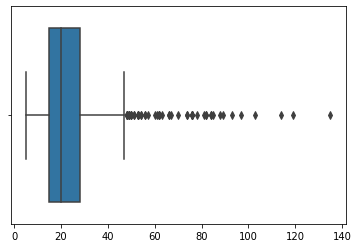

In [24]:

sns.boxplot(lengths)
plt.show()

In [25]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQ_LENGTH = max(lengths)  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_1, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_1, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [26]:
Y_padded.shape

(787, 135)

In [27]:
X_padded.shape

(787, 135)

In [28]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

Y_padded = to_categorical(Y_padded)

In [29]:
X, Y = X_padded, Y_padded
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_padded, Y_padded, test_size=VALID_SIZE, random_state=4)

In [30]:
Y_padded.shape

(787, 135, 96)

In [ ]:
#from imblearn.over_sampling import SMOTE 
#sm = SMOTE(random_state=12, ratio = 1.0)
#x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)

In [31]:


# create architecture
VOCABULARY_SIZE = 135
EMBEDDING_SIZE = 135
MAX_SEQ_LENGTH = 135
NUM_CLASSES = Y.shape[2]
rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(Bidirectional(LSTM(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
)))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [32]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
rnn_model.summary()
rnn_training = rnn_model.fit(x_train_res, y_train_res, batch_size=16, epochs=30, validation_data=(X_validation, Y_validation))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 135, 135)          18225     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 135, 128)          102400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 135, 96)           12384     
Total params: 133,009
Trainable params: 114,784
Non-trainable params: 18,225
_________________________________________________________________
Train on 668 samples, validate on 119 samples
Epoch 1/30
668/668 [==============================] - 24s 36ms/step - loss: 2.0904 - acc: 0.8018 - val_loss: 0.9078 - val_acc: 0.8216
Epoch 2/30
668/668 [==============================] - 21s 31ms/step - loss: 0.8124 - acc: 0.8216 - val_loss: 0.7600 - val_acc: 0.8216
Epoch 3/30
668/668 [==============================] - 22s 3

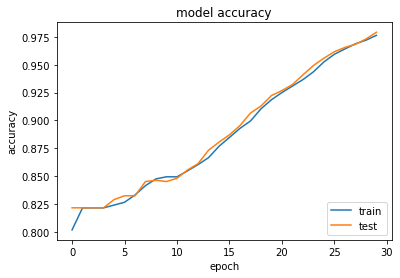

In [33]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()